In [1]:
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.3 MB/s 
     |████████████████████████████████| 588.3 MB 6.2 kB/s 
     |████████████████████████████████| 439 kB 64.7 MB/s 
     |████████████████████████████████| 6.0 MB 7.6 MB/s 
     |████████████████████████████████| 1.7 MB 45.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.1

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [5]:
import pandas as pd
df= pd.read_csv("spam.csv",encoding = "ISO-8859-1")
df =df[['v1','v2']]
df.columns= ['Category','Message']
df.head(3)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [6]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    653  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [7]:
df.Category.value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [8]:
df_ham=df[df.Category=='ham']
df_spam=df[df.Category=='spam']
df_ham.shape
df_ham_downsampled= df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape


(747, 2)

In [9]:
df_balanced=pd.concat([df_spam,df_ham_downsampled])

In [10]:
df_balanced['spam']=df_balanced.Category.apply(lambda x:1 if x=='spam' else 0)
df_balanced.sample(6)

,Category,Message,spam
3057,spam,You are now unsubscribed all services. Get ton...,1
2099,spam,"SMS SERVICES. for your inclusive text credits,...",1
2114,spam,Sunshine Hols. To claim ur med holiday send a ...,1
1829,spam,Hottest pics straight to your phone!! See me g...,1
4364,ham,Ujhhhhhhh computer shipped out with address to...,0
1141,spam,I don't know u and u don't know me. Send CHAT ...,1


In [11]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest= train_test_split(df_balanced.Message, df_balanced.spam,stratify=df_balanced.spam)

In [12]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [13]:
def get_sentence_embedding(sentence):
  preprocessed_text= bert_preprocess(sentence)
  return bert_encoder(preprocessed_text)['pooled_output']
  

In [16]:
# bert layers
text_input= tf.keras.layers.Input(shape=(),dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

#Neural Network Layers
l=tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l=tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)

#Final Model
model=tf.keras.Model(inputs=[text_input],outputs=[l])


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [18]:
Metrics = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=Metrics)

In [21]:
model.fit(xtrain,ytrain,epochs=5)

Epoch 1/5
35/35 [==============================] - 513s 15s/step - loss: 0.5495 - accuracy: 0.7598 - precision: 0.7670 - recall: 0.7464
Epoch 2/5
35/35 [==============================] - 509s 15s/step - loss: 0.4654 - accuracy: 0.8429 - precision: 0.8299 - recall: 0.8625
Epoch 3/5
35/35 [==============================] - 509s 15s/step - loss: 0.4167 - accuracy: 0.8625 - precision: 0.8561 - recall: 0.8714
Epoch 4/5
35/35 [==============================] - 508s 15s/step - loss: 0.3776 - accuracy: 0.8777 - precision: 0.8615 - recall: 0.9000
Epoch 5/5
35/35 [==============================] - 507s 15s/step - loss: 0.3599 - accuracy: 0.8777 - precision: 0.8717 - recall: 0.8857


In [22]:
model.evaluate(xtest,ytest)

12/12 [==============================] - 173s 14s/step - loss: 0.3241 - accuracy: 0.9144 - precision: 0.8934 - recall: 0.9412


[0.3241076171398163, 0.9144384860992432, 0.893401026725769, 0.9411764740943909]

In [23]:
ypred=model.predict(xtest)
ypred = ypred.flatten()

import numpy as np
ypred = np.where(ypred>0.5,1,0)
ypred

12/12 [==============================] - 173s 14s/step


array([1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,

In [26]:
cm= tf.math.confusion_matrix(ytest,ypred)

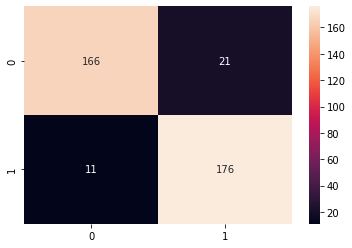

In [27]:
import seaborn as sns
sns.heatmap(cm,annot=True,fmt='d')

In [29]:
text='HY you won 5000 rs in cash'
model.predict([text])

1/1 [==============================] - 3s 3s/step


array([[0.25205073]], dtype=float32)

In [30]:
model.save("saved_model/1")